# Sensor-level RSA example on the kiloword EEG dataset

This example demonstrates how to perform representational similarity analysis (RSA) on EEG data, using a searchlight approach.

In the searchlight approach, representational similarity is computed between the model and searchlight "patches". A patch is defined by a seed point (e.g. sensor Pz) and everything within the given radius (e.g. all sensors within 4 cm. of Pz). Patches are created for all possible seed points (e.g. all sensors), so you can think of it as a "searchlight" that moves from seed point to seed point and everything that is in the spotlight is used in the computation.

The radius of a searchlight can be defined in space, in time, or both. In this example, our searchlight will have a spatial radius of 4 cm. and a temporal radius of 0.1 cm.

The dataset will be the kiloword dataset [1]: approximately 1,000 words were presented to 75 participants in a go/no-go lexical decision task while event-related potentials (ERPs) were recorded.

[1] Dufau, S., Grainger, J., Midgley, KJ., Holcomb, PJ. A thousand words are worth a picture: Snapshots of printed-word processing in an event-related potential megastudy. Psychological science, 2015

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mne
import rsa
import numpy as np
%matplotlib inline

In [3]:
data_path = mne.datasets.kiloword.data_path(verbose=True)
epochs = mne.read_epochs(data_path + '/kword_metadata-epo.fif')

Reading /l/vanvlm1/mne_data/MNE-kiloword-data/kword_metadata-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -100.00 ...     920.00 ms
        0 CTF compensation matrices available
960 matching events found
No baseline correction applied
Adding metadata with 8 columns
0 projection items activated


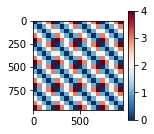

In [33]:
dsm_vis = rsa.compute_dsm(epochs.metadata[['NumberOfLetters']], metric='euclidean')
rsa.plot_dsms(dsm_vis);

In [58]:
rsa_result = rsa.rsa_epochs(epochs, dsm_vis, rsa_metric='pearson',
                            spatial_radius=0.04, temporal_radius=None, tmin=0, tmax=0.2,
                            verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
  0%|          | 0/29 [00:00<?, ?it/s]

[25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75]


100%|██████████| 29/29 [00:01<00:00, 16.21it/s]
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished


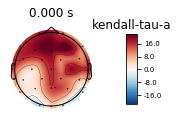

In [59]:
rsa_result.plot_topomap(0, units=dict(eeg='kendall-tau-a'), scalings=dict(eeg=1E3));

In [60]:
rsa_result.data

array([[ 0.02126817],
       [ 0.01678113],
       [ 0.01553595],
       [ 0.00369475],
       [ 0.01827532],
       [ 0.01536964],
       [ 0.01471117],
       [ 0.00554546],
       [-0.00398173],
       [ 0.01999238],
       [ 0.0161316 ],
       [ 0.00192205],
       [ 0.00332949],
       [ 0.01596298],
       [ 0.00942768],
       [ 0.01841416],
       [ 0.01089816],
       [ 0.01294137],
       [ 0.00553347],
       [ 0.0218804 ],
       [ 0.01067057],
       [ 0.00688127],
       [ 0.01142719],
       [ 0.01926608],
       [ 0.01137033],
       [ 0.00951376],
       [ 0.01861875],
       [-0.00398022],
       [-0.00013759]])

In [ ]:
evoked_rsa.plot_topo();

In [ ]:
import gensim

In [ ]:
vecs = gensim.models.KeyedVectors.load_word2vec_format('/m/nbe/project/corpora/englishmodels/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
epochs.metadata.loc[840, 'WORD'] = 'whiskey'  # Alternate spelling
model = vecs[epochs.metadata.WORD]

In [ ]:
import numpy as np
np.save('w2v.npy', model)

In [ ]:
epochs.metadata.query('WORD == "whisky"')